In [1]:
!pip install auto-sklearn

     |████████████████████████████████| 6.4 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 19.6 MB/s eta 0:00:01     |█▉                              | 276 kB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 45.0 MB/s eta 0:00:01
     |████████████████████████████████| 885 kB 93.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 260 kB 25.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 103.7 MB/s eta 0:00:01     |█████████▎                      | 563 kB 103.7 MB/s eta 0:00:01 | 1.7 MB 103.7 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 46 kB 3.7 MB/s  eta 0:00:01
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.7-py3-none-any.whl size=6602856 sha256=582dd5d9ba6eaad626039c7c4d526b9d9cc794550e

In [152]:
from datetime import datetime as dt
from datetime import timedelta
import random
import chardet


import pandas as pd
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [105]:
FILENAME = "MiBolsillo.csv"
ENCODING = chardet.detect(open(FILENAME,'rb').read())['encoding'] # finding the encoding used in the document

In [106]:
df = pd.read_csv(FILENAME, sep=';', encoding=ENCODING, decimal=',', thousands='.')
df.columns = map(lambda x: x.strip(), df.columns) # removing leading and trailing whitespaces, and double spaces

In [107]:
df

,id,safra_abertura,cidade,estado,idade,sexo,limite_total,limite_disp,data,valor,grupo_estabelecimento,cidade_estabelecimento,pais_estabelecimento
0,4.530000e+11,201405,CAMPO LIMPO PAULISTA,SP,37,F,4700,5605,4122019,31,SERVI‚O,SAO PAULO,BR
1,4.530000e+11,201405,CAMPO LIMPO PAULISTA,SP,37,F,4700,5343,9112019,"150,01",FARMACIAS,SANTOS,BR
2,4.530000e+11,201405,CAMPO LIMPO PAULISTA,SP,37,F,4700,2829,6052019,50,SERVI‚O,SAO PAULO,BR
3,4.530000e+11,201405,CAMPO LIMPO PAULISTA,SP,37,F,4700,2547,1062019,"54,4",M.O.T.O.,OSASCO,BR
4,4.530000e+11,201405,CAMPO LIMPO PAULISTA,SP,37,F,4700,2515,1062019,"32,79",M.O.T.O.,OSASCO,BR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,9.190000e+11,201910,SAO PAULO,SP,37,M,8500,5305,23012020,"25,5",RESTAURANTE,SAO PAULO,BR
4951,9.190000e+11,201910,SAO PAULO,SP,37,M,8500,5266,23012020,"39,5",SUPERMERCADOS,SAO PAULO,BR
4952,9.190000e+11,201910,SAO PAULO,SP,37,M,8500,5445,19022020,"75,56",RESTAURANTE,SAO PAULO,BR
4953,9.190000e+11,201910,SAO PAULO,SP,37,M,8500,5002,30032020,"5,9",SERVI‚O,SAO PAULO,BR


## Data Cleaning

In [108]:
REFERENCE_DATE = dt.strptime("1970/01", "%Y/%m")

def safra_to_deltatime(date_int) -> int:
    ''' Converting date from YYYYMM to delta days
    '''
    date_str = str(date_int)
    date = dt.strptime(date_str, "%Y%m")
    return (date - REFERENCE_DATE).days

def intdata_to_deltatime(date_int) -> int:
    ''' Converting date from DDMMYYY to delta days
    '''
    date_str = f"{date_int:08}"
    date = dt.strptime(date_str, "%d%m%Y")
    return (date - REFERENCE_DATE).days

def strnum_to_float(strnum) -> float:
    ''' Converting number string to float
    '''
    if isinstance(strnum, float):
        return strnum
    if isinstance(strnum, int):
        return float(strnum)
    if strnum.strip() == '-':
        return None
    return float(strnum.replace('.','').replace(',','.'))

In [109]:
gender_to_id = {'M':1,'F':2} # creating ids for each gender presented in the dataset
estab_to_id = {v:i for i,v in enumerate(df['grupo_estabelecimento'].unique())} # creating ids for each group presented in the dataset
city_to_id = {v:i for i,v in enumerate(df['cidade'].unique())} # creating ids for each city presented in the dataset
city_estab_to_id = {v:i for i,v in enumerate(df['cidade_estabelecimento'].unique())} # creating ids for each city presented in the dataset
state_to_id = {v:i for i,v in enumerate(df['estado'].unique())} # creating ids for each state presented in the dataset
country_to_id = {v:i for i,v in enumerate(df['pais_estabelecimento'].unique())} # creating ids for each country presented in the dataset
client_to_code = {v:i for i,v in enumerate(df['id'].unique())} # assigning an integer for each client

df_numeric = pd.DataFrame({})

# converting non-numeric values
df_numeric['client_id'] = df['id'].apply(lambda x: client_to_code[x])
df_numeric['sexo_id'] = df['sexo'].apply(lambda x: gender_to_id[x.upper()] if x.upper() in gender_to_id else 3) # applying ids
df_numeric['estab_id'] = df['grupo_estabelecimento'].apply(lambda x: estab_to_id[x]) # applying ids
df_numeric['city_id'] = df['cidade'].apply(lambda x: city_to_id[x]) # applying ids
df_numeric['city_estab_id'] = df['cidade_estabelecimento'].apply(lambda x: city_estab_to_id[x]) # applying ids
df_numeric['state_id'] = df['estado'].apply(lambda x: state_to_id[x]) # applying ids
df_numeric['country_id'] = df['pais_estabelecimento'].apply(lambda x: country_to_id[x])
df_numeric['safra_dt'] = df['safra_abertura'].apply(safra_to_deltatime) # converting data to deltatime
df_numeric['data_dt'] = df['data'].apply(intdata_to_deltatime) # converting data to deltatime
df_numeric['amount'] = df['valor'].apply(strnum_to_float).fillna(0) # converting numeric string to float
df_numeric['total_limit'] = df['limite_total'].apply(strnum_to_float) # converting numeric string to float
df_numeric['available_limit'] = df['limite_disp'].apply(strnum_to_float) # converting numeric string to float
df_numeric['data_datetime'] = df['data'].apply(lambda x: dt.strptime(str(f"{x:08}"), '%d%m%Y'))

# new variables
df_numeric['limit_ratio'] = df_numeric['available_limit']/df_numeric['total_limit']

# reutilizing the numeric values
df_numeric['age'] = df['idade'].copy()

df_numeric

,client_id,sexo_id,estab_id,city_id,city_estab_id,state_id,country_id,safra_dt,data_dt,amount,total_limit,available_limit,data_datetime,limit_ratio,age
0,0,2,0,0,0,0,0,16191,18234,31.00,4700.0,5605.0,2019-12-04,1.192553,37
1,0,2,1,0,1,0,0,16191,18209,150.01,4700.0,5343.0,2019-11-09,1.136809,37
2,0,2,0,0,0,0,0,16191,18022,50.00,4700.0,2829.0,2019-05-06,0.601915,37
3,0,2,2,0,2,0,0,16191,18048,54.40,4700.0,2547.0,2019-06-01,0.541915,37
4,0,2,2,0,2,0,0,16191,18048,32.79,4700.0,2515.0,2019-06-01,0.535106,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,22,1,11,1,0,0,0,18170,18284,25.50,8500.0,5305.0,2020-01-23,0.624118,37
4951,22,1,10,1,0,0,0,18170,18284,39.50,8500.0,5266.0,2020-01-23,0.619529,37
4952,22,1,11,1,0,0,0,18170,18311,75.56,8500.0,5445.0,2020-02-19,0.640588,37
4953,22,1,0,1,0,0,0,18170,18351,5.90,8500.0,5002.0,2020-03-30,0.588471,37


## Data Analysis

Here we can see the proportion of each class in "grupo estabelecimento"

it's good to keep in mind that this result is biased by the distribution of the 'grupo_estabelecimento', that is not equally distributed

since the bias is present also in the test set, it's ok to use as is now, but in the future, if the semantics of the data changes, we'll need to retrain the model. 

if the dataset were bigger, we could filter some data, making the occurrences of 'grupo estabelecimento' equally distributed.

In [1]:
#df_numeric['estab_id'].replace({v:k for k,v in estab_to_id.items()}).hist(color='blue', xrot=90, rwidth=0.2)
df_numeric['estab_id'].replace({v:k for k,v in estab_to_id.items()}).value_counts().plot.bar()

NameError: name 'df_numeric' is not defined

a timeline of total spending in credit card by a rolling window of 15 days
we can see that right in the beggining of covid (february 2020) there were an outburst in spenditures

<AxesSubplot:xlabel='data_datetime'>

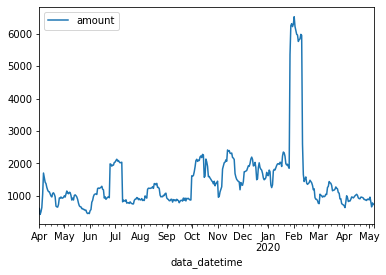

In [121]:
total_spending_view = df_numeric.groupby('data_datetime').agg({'amount':'sum'}).rolling('15d').mean()
total_spending_view.plot()


this burst period from february can create a bias in the data if we check for the mean amount spent during pre and post covid, since our whole dataset ends at may,
presenting a decreasing trend, having the burst only in february and not presenting a trend. So for future cases, we should delete this period from our data so it doesn't influence on our predictions

---

we can obtain this exact period by filtering this query by any value bigger than 4000 and getting the min and max dates

In [112]:
burst_period = total_spending_view[total_spending_view['amount']>4000]
burst_start = burst_period.reset_index()['data_datetime'].iloc[0]
burst_end = burst_period.reset_index()['data_datetime'].iloc[-1]

print(f"burst start: {str(burst_start).split()[0]}\nburst end: {str(burst_end).split()[0]}")

burst start: 2020-01-27
burst end: 2020-02-10


comparing to the burst period, how is the establishment spending trend compared to the usual period?

<ipython-input-139-9935a04d11fb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_burst['estab_id'] = no_burst['estab_id'].replace({v:k for k,v in estab_to_id.items()})#.value_counts()


<AxesSubplot:xlabel='estab_id'>

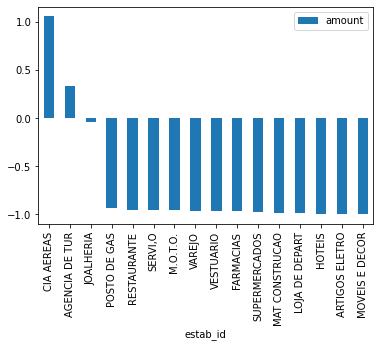

In [139]:
burst_view = df_numeric.copy()
no_burst_view = df_numeric.copy()

keys = burst_period.index.values

burst_view = burst_view[burst_view['data_datetime'].isin(keys)]
no_burst = no_burst_view[~no_burst_view['data_datetime'].isin(keys)]

burst_view['estab_id'] = burst_view['estab_id'].replace({v:k for k,v in estab_to_id.items()})#.value_counts()
burst_spendings = burst_view.groupby('estab_id').agg({'amount':'sum'})

no_burst['estab_id'] = no_burst['estab_id'].replace({v:k for k,v in estab_to_id.items()})#.value_counts()
no_burst_spendings = no_burst.groupby('estab_id').agg({'amount':'sum'})

((burst_spendings/no_burst_spendings)-1).dropna().sort_values('amount', ascending=False).plot.bar()

removing burst period

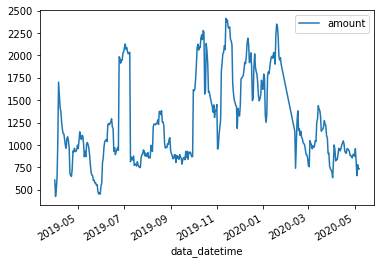

In [11]:
burst_start = dt.strptime("2020-01-26","%Y-%m-%d") # one day less
burst_end = dt.strptime("2020-02-11", "%Y-%m-%d") # one day more

df_numeric2 = df_numeric[(df_numeric['data_datetime']<burst_start)|(df_numeric['data_datetime']>burst_end)]
total_spending_view = df_numeric2.groupby('data_datetime').agg({'amount':'sum'}).rolling('15d').mean()
total_spending_view.plot()#.sort_values('amount', ascending=False)

df_numeric = df_numeric2 # remove for atomic cell

creating two dataframes, one for pre covid and another for pos covid

In [12]:
expr = df_numeric['data_datetime'] < dt.strptime("01-2020","%m-%Y")
df_pre_covid = df_numeric[expr].copy()
df_pos_covid = df_numeric[~expr].copy()

let's measure the number of days from the date we defined as the start of covid (01-01-2020) and
select the same number of days from before covid, so when we compare those two, we compare from an equal time window

In [13]:
end_of_data = df_pos_covid['data_datetime'].max()
start_of_data = df_pre_covid['data_datetime'].min()

print(f"start: {start_of_data}, end: {end_of_data}, interval: {(end_of_data-start_of_data).days}")

start: 2019-04-01 00:00:00, end: 2020-05-07 00:00:00, interval: 402


In [14]:
(end_of_data - dt.strptime("01-2020","%m-%Y")).days

127

so we have a total of 402 days on our whole dataset but only 127 of those represent the pos covid period. So we should select the first 127 days 

of the pre-covid dataset as a reference for "pre-covid data"

In [15]:
final_date = start_of_data + timedelta(days=127)
df_pre_covid = df_pre_covid[df_pre_covid['data_datetime'] <= final_date].copy() # resizing

In [16]:
feature = "amount"

print(f"pre covid: {df_pre_covid[feature].mean()}\npos covid: {df_pos_covid[feature].mean()}")

# numbers if we didn't remove the burst period:
# pre covid: 92.15921107266436
# pos covid: 160.11911660777383

pre covid: 92.15921107266436
pos covid: 115.52865502183406


In this case we used std instead of mean because the point is to show the outlier biasing the data.

With the mean the impact of an outlier is reduced

it's important to note that we should not use the sum of amount here because we have more data from before covid than after

In the pos-covid period we have a smaller spending trend (and decreasing), and even so it has a mean greater than pre covid

that happens because of the burst outlier that might not repeat in the future, biased by the outliers

---

#### total limit

a timeline of total credit limit by a rolling window of 15 days

<AxesSubplot:xlabel='data_datetime'>

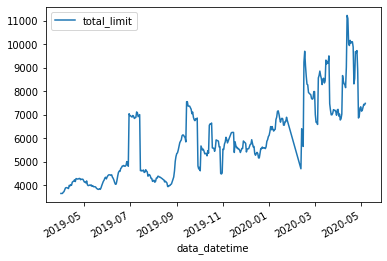

In [17]:
df_numeric.groupby('data_datetime').agg({'total_limit':'median'}).rolling('15d').mean().plot()

Here we can see an upwards trend in the whole dataset, but it becomes more intense at the start of the covid.

It also became more volatile

Let's visualize this statement better:

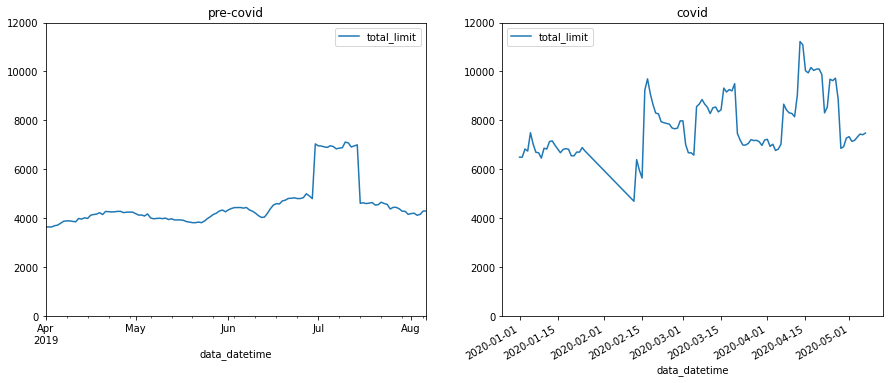

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_pre_covid.groupby('data_datetime').agg({'total_limit':'median'}).rolling('15d').mean().plot(ax=axes[0])
axes[0].set_title('pre-covid')
axes[0].set_yticks(range(0,13000,2000))
df_pos_covid.groupby('data_datetime').agg({'total_limit':'median'}).rolling('15d').mean().plot(ax=axes[1])
axes[1].set_title('covid')
axes[1].set_yticks(range(0,13000,2000))

In [19]:
feature = "total_limit"

print(f"pre covid: {df_pre_covid[feature].mean()}\npos covid: {df_pos_covid[feature].mean()}")

# numbers if we hadn't removed the burst period:
# pre covid: 6094.865051903114
# pos covid: 10624.118727915195

pre covid: 6094.865051903114
pos covid: 10608.199126637555


we can see that during covid period, the standard deviation of the credit limit of consumers' credit increased by 74%

meaning that the volatility of total_credit increased

* here we chose to use median because there are some outliers in the dataset around august 2019
---

#### Covid influence on behavior on grupo_estabelecimento

pre covid: 

<AxesSubplot:xlabel='estab_name'>

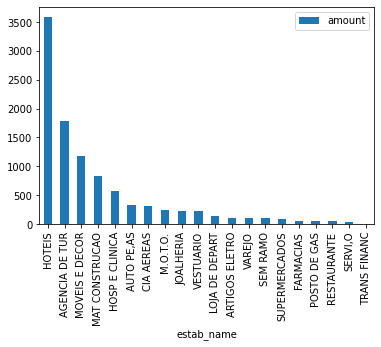

In [20]:
reverse_estab_id = {v:k for k,v in estab_to_id.items()}

df_pre_covid['estab_name'] = df_pre_covid['estab_id'].apply(lambda x: reverse_estab_id[x])
df_pos_covid['estab_name'] = df_pos_covid['estab_id'].apply(lambda x: reverse_estab_id[x])

pre_hist = df_pre_covid.groupby('estab_name').agg({'amount':'mean'})
pos_hist = df_pos_covid.groupby('estab_name').agg({'amount':'mean'})

pre_hist.sort_values('amount', ascending=False).plot.bar()

covid period: 

<AxesSubplot:xlabel='estab_name'>

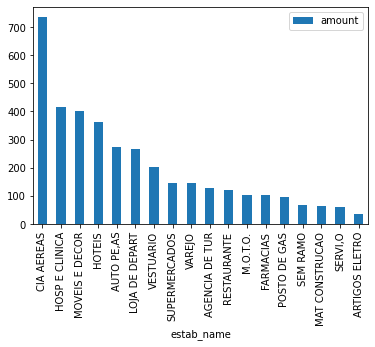

In [21]:
pos_hist.sort_values('amount', ascending=False).plot.bar()

Rate of change of purchases between pre and pos covid:

<AxesSubplot:xlabel='estab_name'>

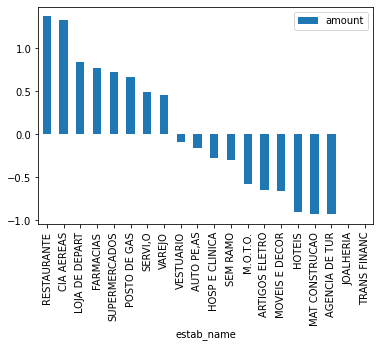

In [142]:
((pos_hist/pre_hist)-1).sort_values('amount', ascending=False).plot.bar()

We can check the validity of the increase on flight sector by looking at the time series of amount spent with flights over time:

<AxesSubplot:xlabel='data_datetime'>

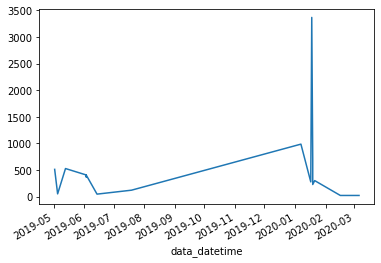

In [23]:
flight_pre = df_pre_covid[df_pre_covid['estab_name']=='CIA AEREAS'].set_index('data_datetime')['amount']
flight_pos = df_pos_covid[df_pos_covid['estab_name']=='CIA AEREAS'].set_index('data_datetime')['amount']

flight_view = pd.concat([flight_pre, flight_pos])
flight_view.plot()

The flight burst happened right before and during the burst period we removed earlier

without removing it, we would see more spikes like this one above, around the same period as this one happened

## Feature Engineering

#### Selecting features

Getting the absolute values for the correlation matrix of the "grupo estabelecimento" id

getting absolutes because we need the best candidates for a feature; so only the magnitude is important right now

<AxesSubplot:>

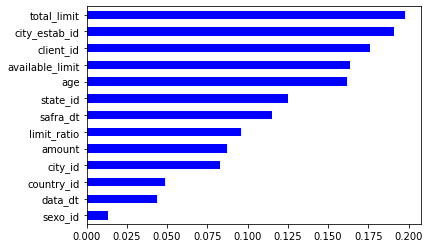

In [24]:
df_numeric.corr()['estab_id'].apply(lambda x: abs(x)).sort_values(ascending=True).iloc[:-1].plot.barh(color='blue')


Getting the average available_limit, total_limit and value for each grupo_estabelecimento

Amount by establishment group:

<AxesSubplot:ylabel='estab_id'>

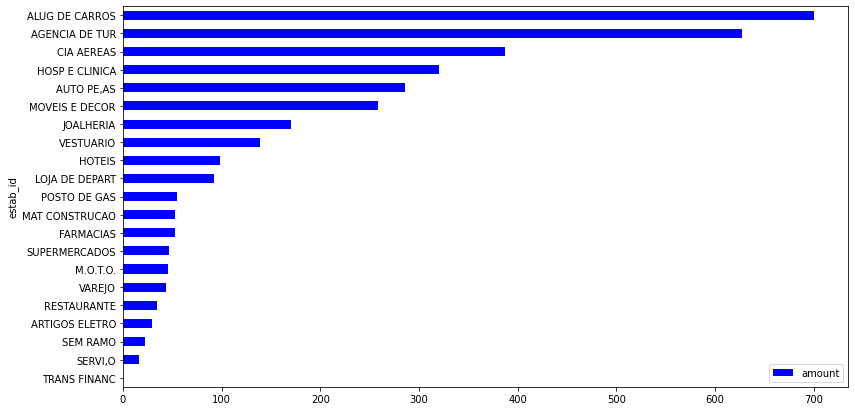

In [27]:
df_amount = df_numeric.groupby('estab_id', as_index=False).agg({'amount':'median'}).sort_values('amount', ascending=True)
df_amount['estab_id'] = df_amount['estab_id'].replace({v:k for k,v in estab_to_id.items()})
df_amount = df_amount.set_index('estab_id')
df_amount.plot.barh(figsize=(13,7), color={'amount':'blue'})

If the burst period weren't removed, we would see a discrepancy from the tag "INEXISTENTE" over others (much higher) that would make all the
other values proportionaly low, that might hinder the model evaluation, so when normalizing the values over 0~1 we could experiment with capping the value over 2000 or 3000 (anything >= those values equals 1), or using a log function. That weren't necessary because the removal of the
burst period made the values much more equally distributed. 

If the scaling were necessary, it would be better to use log instead of min-max, because to use the min-max scaling we should always run a full scan on the entire set looking for the max and min values, which might change over time when the dataset increases in the future.

In this alternative scenario, what would happen in the distribution of values is this:

<AxesSubplot:ylabel='estab_id'>

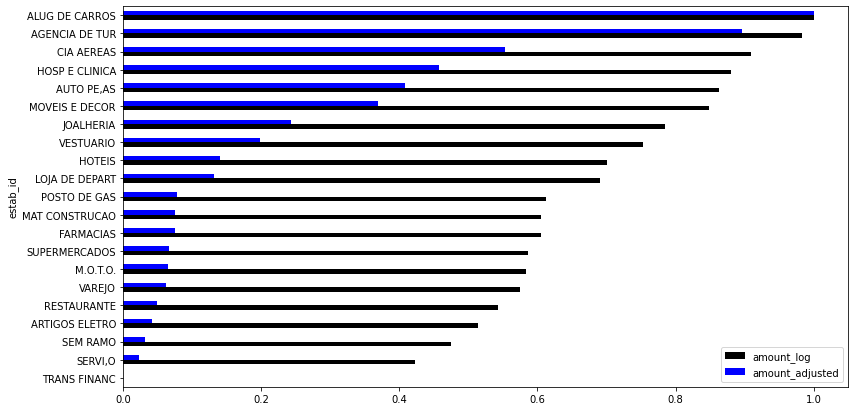

In [143]:
df_amount['amount_log'] = df_amount['amount'].apply(lambda x: max(np.log(x),0)) # applying log to amount variable
df_amount['amount_log'] = df_amount['amount_log']/df_amount['amount_log'].max() # normalizing between 0~1 so we can compare both in the same max values
df_amount['amount_adjusted'] = df_amount['amount']/df_amount['amount'].max() # normalizing between 0~1 so we can compare both in the same max values
df_amount[['amount_log', 'amount_adjusted']].plot.barh(color={'amount_log':'black','amount_adjusted':'blue'}, figsize=(13,7), stacked=False)

* same data as above (red) but adjusted with log (black)

---

Total limit by establishment group:

<AxesSubplot:ylabel='estab_id'>

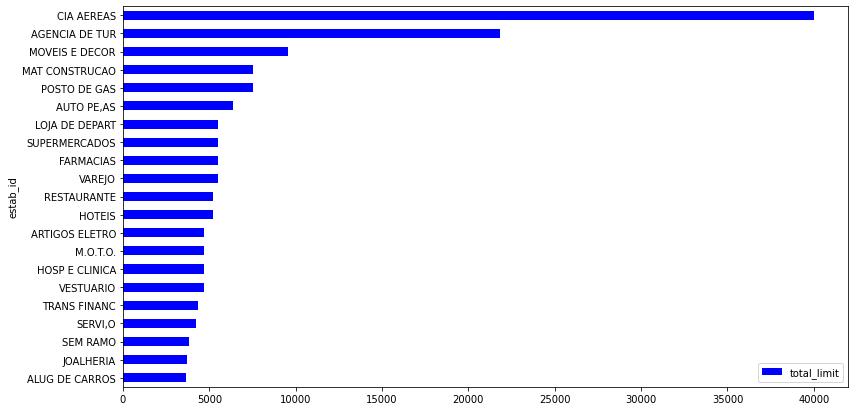

In [29]:
df_total_limit = df_numeric.groupby('estab_id', as_index=False).agg({'total_limit':'median'}).sort_values('total_limit', ascending=True)
df_total_limit['estab_id'] = df_total_limit['estab_id'].replace({v:k for k,v in estab_to_id.items()})
df_total_limit = df_total_limit.set_index('estab_id')
df_total_limit.plot.barh(color='blue', figsize=(13,7))

Available limit by establishment group:

<AxesSubplot:ylabel='estab_id'>

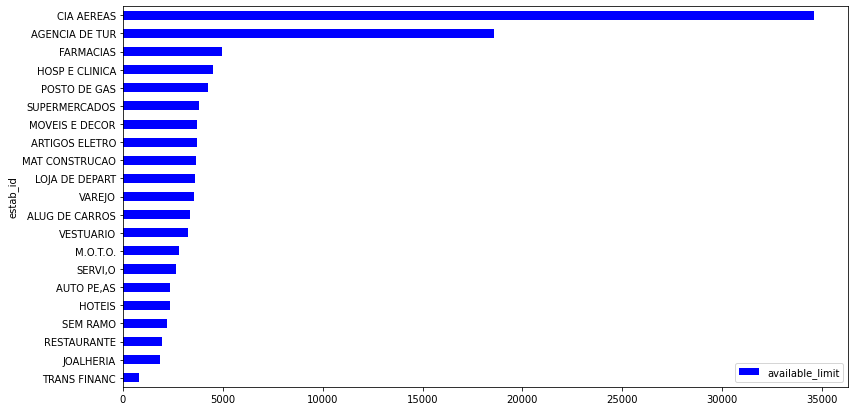

In [30]:
df_avail_limit = df_numeric.groupby('estab_id', as_index=False).agg({'available_limit':'median'}).sort_values('available_limit', ascending=True)
df_avail_limit['estab_id'] = df_avail_limit['estab_id'].replace({v:k for k,v in estab_to_id.items()})
df_avail_limit = df_avail_limit.set_index('estab_id')
df_avail_limit.plot.barh(color='blue', figsize=(13,7))

All the previous three together, sorted by total magnitude:

<AxesSubplot:ylabel='estab_id'>

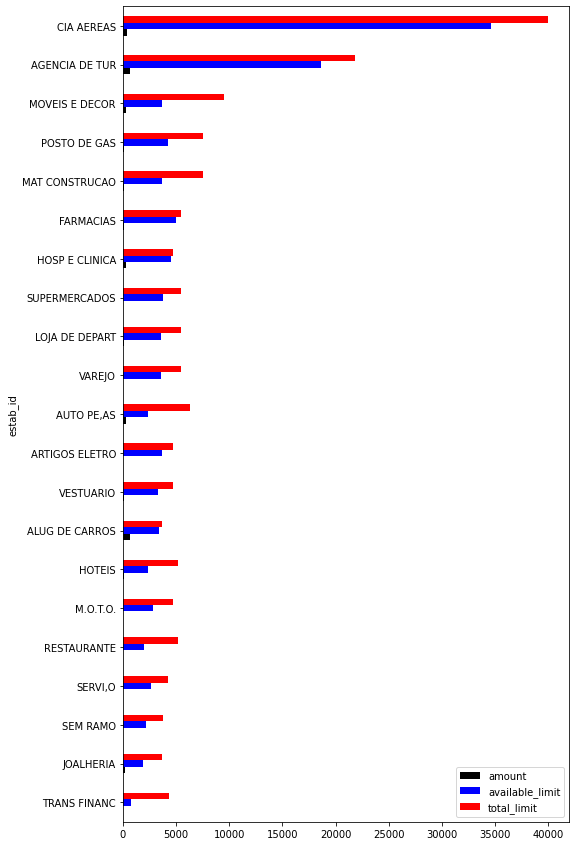

In [31]:
colors = {'amount':'black','available_limit':'blue', 'total_limit':'red'}
df_money = pd.concat([df_amount, df_avail_limit, df_total_limit], axis=1)
df_money['sort_key'] = df_money['amount'] + df_money['available_limit'] + df_money['total_limit']
df_money = df_money.sort_values('sort_key')
df_money[list(colors.keys())].plot.barh(color=colors, figsize=(8,15))

#### Creating new features

Judging by the correlation results, we can see that the client_id can be relevant to the target feature. So let's see if clients has preference for one kind of 'grupo_estabelecimento' over other groups

The assumption being validated here is if just by looking at a client_id we can infer the 'group_estabelecimento' of his purchase

In other words: 

how probable is that he will buy the 'grupo_estabelecimento' that's most often used by him/her in a specific purchase

$p(preferred\_grupo\_estabelecimento  |  client\_id)$

Creating train and test set:

In [145]:
df_num_shuffled = df_numeric.copy().sample(frac=1, random_state=0) 

shuffling the data so we don't get a test set biased by covid period

nor by yearly trends between training and test sets

In [146]:
ds_size = df_num_shuffled.shape[0]
train_size = int(ds_size*0.8)
test_size = ds_size - train_size

df_train = df_num_shuffled.iloc[:train_size]
df_test = df_num_shuffled.iloc[train_size:]

Finding the 'grupo_estabelecimento' that appears the most for each client. If it's a draw, select a random one

In [147]:
clients = {}
for row in df_train.iterrows():
    cid = row[1]['client_id']
    if cid not in clients:
        clients[cid] = []
    clients[cid].append(row[1]['estab_id'])

def get_most_frequent(values):
    return max(set(values), key=values.count)

id_to_pref_estab = {k:int(get_most_frequent(v)) for k,v in clients.items()}

Now let's see how many 'grupo_estabelecimento' we will get right solely by using the client_id preferred value

let's use a different sample than we used for finding the preferred id, so we don't get a biased inference

In [148]:
df_id_test = df_test.copy()
df_id_test['preferred'] = df_test['estab_id'].apply(lambda x: id_to_pref_estab[x])
df_id_test['match'] = df_id_test['preferred'] == df_id_test['estab_id']
df_id_test = df_id_test[['estab_id', 'preferred', 'match']]
df_id_test

,estab_id,preferred,match
734,11,0,False
4175,11,0,False
2514,0,0,True
336,4,0,False
2596,11,0,False
...,...,...,...
4931,17,13,False
3264,0,0,True
1653,0,0,True
2607,10,11,False


Calculating the probability of getting the right estab_id by using the preferred id

In [34]:
false_count = df_id_test['match'].value_counts()[0]
true_count = df_id_test['match'].value_counts()[1]
print(f"{true_count}/{true_count + false_count} = {true_count/(true_count+false_count)}")

314/937 = 0.33511205976520814


Control set:

In [159]:
df_id_control = df_id_test.copy()
ids = df_id_control['estab_id'].drop_duplicates().values
df_id_control['preferred'] = df_id_control['preferred'].apply(lambda x: random.choice(ids))
df_id_control['match'] = df_id_control['preferred'] == df_id_control['estab_id']

false_count = df_id_control['match'].value_counts()[0]
true_count = df_id_control['match'].value_counts()[1]
print(f"{true_count}/{true_count + false_count} = {true_count/(true_count+false_count)}")

66/991 = 0.06659939455095863


That means that the probability of finding the right 'grupo_estabelecimento' given 'preferred grupo_estabelecimento' is 33%

which is greater than random choice for 22 options (6% for random choice, 4.5% if were equally distributed)

Since this feature has shown a significance of 33% over 6%, let's keep it for our model and test results with and without it

---

TODO:
* mostrar o que mais foi comprado durante o burst
* tirar uma conclusao sobre a analise pre e pos pandemia, incluir suposicao sobre aeroportos e aumento em numero de voos
* deletar o burst de fevereiro do ds
* model without any constraints, just using the initial data as is
* model with values scaled with log and using the added features and without the february burst

* fazer o modelo bruto
* nao fazer fine tuning
* investir em engenharia de feature
* adicionar features de estabelecimento preferido de determinada cidade, de determinado estado e de determinada idade, e sexo, acrescentando essas colunas no ds
* adicionar feature de bool se é weekend ou nao
* falar de ensemble models(verificar se é mesmo) para hierarquical taxonomy, usar um modelo para a
categoria principal, e outro para cada sub categoria
* check for linear separability and justify using or not using SVM
* it's a classification problem, not a regression one


## Results

#### Model Experimentation

Converting values to one-hot and scaling

* scaling: most models interpret numbers as signal intensity, that means converting numeric values from unbounded scales into between 0 and 1, while mantaining its original order. 
  Ages 18 and 99 could become 0.1 and 0.99, depending on the demography on the dataset

* one-hot: some values that represent classes becomes more evident for the model if it's classes are not represented by a region between 0 and 1, but with each class having it's own value, that can be either 0 or 1. 

    So a value that between 0 and 0.5 represents heads, and >0.5 and 1 represent tails, would be better represented if we increase a dimension for each class

    becoming (0,1) for heads and (1,0) for tails


In [36]:

def col_to_one_hot(df_ref, df_input, col_name, classes=None):
    df_out = df_input.copy()
    if classes:
        values = classes
    else:
        values = df_ref[col_name].drop_duplicates().values.tolist()
    print(f"{col_name} classes: {len(values)}")
    names = {f"{col_name}_{v}":v for v in values}
    for k in names:
        df_out[k] = df_ref[col_name].apply(lambda x: 1 if x==names[k] else 0)
    return df_out, values

def col_to_scaled(df_ref, df_input, col_name):
    df_input = df_input.copy()
    max_v = df_ref[col_name].max()
    min_v = df_ref[col_name].min()
    df_input[col_name] = df_ref[col_name].apply(lambda x: (x-min_v)/(max_v-min_v))
    return df_input

#df_numeric['sexo_id'].drop_duplicates().values.tolist()

df_X_train = pd.DataFrame({})
df_y_train = pd.DataFrame({})

df_X_test = pd.DataFrame({})
df_y_test = pd.DataFrame({})

# Train
df_y_train, estab_id_classes = col_to_one_hot(df_train, df_y_train, 'estab_id')

#df_X_train, client_id_classes = col_to_one_hot(df_train, df_X_train, 'client_id')
df_X_train, sexo_id_classes = col_to_one_hot(df_train, df_X_train, 'sexo_id')
df_X_train, city_id_classes = col_to_one_hot(df_train, df_X_train, 'city_id')
df_X_train, city_estab_id_classes = col_to_one_hot(df_train, df_X_train, 'city_estab_id')
df_X_train, state_id_classes = col_to_one_hot(df_train, df_X_train, 'state_id')
df_X_train = col_to_scaled(df_train, df_X_train, 'amount')
df_X_train = col_to_scaled(df_train, df_X_train, 'total_limit')
df_X_train = col_to_scaled(df_train, df_X_train, 'age')
df_X_train = col_to_scaled(df_train, df_X_train, 'data_dt')

# Test
df_y_test, c = col_to_one_hot(df_test, df_y_test, 'estab_id', classes=estab_id_classes)

#df_X_test, c = col_to_one_hot(df_test, df_X_test, 'client_id', classes=client_id_classes)
df_X_test, c = col_to_one_hot(df_test, df_X_test, 'sexo_id', classes=sexo_id_classes)
df_X_test, c = col_to_one_hot(df_test, df_X_test, 'city_id', classes=city_id_classes)
df_X_test, c = col_to_one_hot(df_test, df_X_test, 'city_estab_id', classes=city_estab_id_classes)
df_X_test, c = col_to_one_hot(df_test, df_X_test, 'state_id', classes=state_id_classes)
df_X_test = col_to_scaled(df_test, df_X_test, 'amount')
df_X_test = col_to_scaled(df_test, df_X_test, 'total_limit')
df_X_test = col_to_scaled(df_test, df_X_test, 'age')
df_X_test = col_to_scaled(df_test, df_X_test, 'data_dt')



df_X_test

estab_id classes: 20
sexo_id classes: 2
city_id classes: 10
city_estab_id classes: 121
state_id classes: 2
estab_id classes: 20
sexo_id classes: 2
city_id classes: 10
city_estab_id classes: 121
state_id classes: 2


,sexo_id_2,sexo_id_1,city_id_1,city_id_4,city_id_8,city_id_2,city_id_0,city_id_9,city_id_6,city_id_5,...,city_estab_id_123,city_estab_id_67,city_estab_id_135,city_estab_id_137,state_id_0,state_id_1,amount,total_limit,age,data_dt
4943,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.006181,0.206549,0.515152,0.699005
3790,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.012258,0.084383,0.212121,0.276119
4672,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0.009076,0.098237,0.242424,0.373134
4068,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.025537,0.084383,0.212121,0.721393
88,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0.005485,0.110831,0.515152,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.009727,0.123426,0.424242,0.592040
3472,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.006441,0.093199,0.424242,0.166667
1746,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0.042925,0.098237,0.242424,0.793532
2783,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.009434,0.060453,0.303030,0.186567


Checking if train and test has the same number of columns:

In [37]:
print(f"{df_X_train.shape[1]} = {df_X_test.shape[1]}")
print(f"{df_y_train.shape[1]} = {df_y_test.shape[1]}")

139 = 139
20 = 20


 Now let's add the raw data to the model to see how it goes
 
 A SVM model doesn't perform when data are not linear separable. It also has only one output node, so our task 
 
 of multi classification can not be performed by a single svm if we want a one-hot output
 
 (and for some features, not by any SVM at all, because SVM does not suparates data that are not linear separable)
 
---

 But as an initial experiment let's use a One-Vs-All method, it uses a SVM model for each feature, and compare the result of each one
 
 to find the one with the most intense output signal. This method doesn't solve our linear separability problem, but solves our multi-class one

In [38]:
X = np.array(df_X_train)
y = np.array(df_y_train)
X_test = np.array(df_X_test)
y_test = np.array(df_y_test)

# one vs all method (for insight on each individual feature)
lsvc = OneVsRestClassifier(LinearSVC(random_state=0))
lsvc.fit(X, y)
pred = lsvc.predict(X_test)
metrics.accuracy_score(pred, y_test)


0.21237993596584845

We can see that it reached a 21% accuracy score. Mostly due to the region and client features

This behavior was partly predicted by our correlation analysis back then, but the continuous features (total_limit, etc...) did not perform

as expected. It's possible that it occurs because they are not linear separable as said earlier

---

Now let's add our engineered features and see how it changes the model' performance:

In [161]:
df_train['id_pref'] = df_train['client_id'].map(id_to_pref_estab)
df_test['id_pref'] = df_test['client_id'].map(id_to_pref_estab)

df_X_train2 = df_X_train.copy()
df_X_test2 = df_X_test.copy()

df_X_train2, id_pref_classes = col_to_one_hot(df_train, df_X_train2, 'id_pref')
df_X_test2, c = col_to_one_hot(df_test, df_X_test2, 'id_pref', classes=id_pref_classes)

df_X_test2

id_pref classes: 5
id_pref classes: 5


<ipython-input-161-042d1bf13282>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['id_pref'] = df_train['client_id'].map(id_to_pref_estab)
<ipython-input-161-042d1bf13282>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['id_pref'] = df_test['client_id'].map(id_to_pref_estab)


,sexo_id_2,sexo_id_1,city_id_1,city_id_4,city_id_8,city_id_2,city_id_0,city_id_9,city_id_6,city_id_5,...,state_id_1,amount,total_limit,age,data_dt,id_pref_11,id_pref_0,id_pref_6,id_pref_13,id_pref_4
4943,0,1,1,0,0,0,0,0,0,0,...,0,0.006181,0.206549,0.515152,0.699005,NaN,NaN,NaN,NaN,NaN
3790,0,1,1,0,0,0,0,0,0,0,...,0,0.012258,0.084383,0.212121,0.276119,NaN,NaN,NaN,NaN,NaN
4672,1,0,0,1,0,0,0,0,0,0,...,0,0.009076,0.098237,0.242424,0.373134,NaN,NaN,NaN,NaN,NaN
4068,0,1,1,0,0,0,0,0,0,0,...,0,0.025537,0.084383,0.212121,0.721393,NaN,NaN,NaN,NaN,NaN
88,1,0,0,0,0,0,1,0,0,0,...,0,0.005485,0.110831,0.515152,0.833333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,1,0,1,0,0,0,0,0,0,0,...,0,0.009727,0.123426,0.424242,0.592040,NaN,NaN,NaN,NaN,NaN
3472,1,0,1,0,0,0,0,0,0,0,...,0,0.006441,0.093199,0.424242,0.166667,NaN,NaN,NaN,NaN,NaN
1746,1,0,0,1,0,0,0,0,0,0,...,0,0.042925,0.098237,0.242424,0.793532,NaN,NaN,NaN,NaN,NaN
2783,1,0,1,0,0,0,0,0,0,0,...,0,0.009434,0.060453,0.303030,0.186567,NaN,NaN,NaN,NaN,NaN


In [41]:

X2 = np.array(df_X_train2)
y = np.array(df_y_train)
X_test2 = np.array(df_X_test2)
y_test = np.array(df_y_test)

# one vs all method (for insight on each individual feature)
lsvc2 = OneVsRestClassifier(LinearSVC(random_state=0))
lsvc2.fit(X2, y)
pred2 = lsvc2.predict(X_test2)
metrics.accuracy_score(pred2, y_test)

0.2945570971184632

We can see that our new features improve the accuracy from 21% to 29%.

The client_id features from our first test was removed, if we wasn't, the model would have 27% precision score

Mantaining the client_id features makes the model ignore the new features that show the preferred establishment of that client, thus lowering the accuracy.

So it was removed.

also, this new feature doesn't increase as the number of clients increases, nor needs a new training for each new client

while using raw client_ids does

---

To overcome the SVM' linear separability limitation, let's experiment with a multiple layer perceptron.

it's capable of combining linear spaces from previous layers making more complex regions for classification.


In [42]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=1000).fit(X2, y)
clf.score(X_test2, y_test)

0.31696905016008536


as we can see, it performs better than SVM, and performs better than solely predicting by chosing the preferred estab_id of that client, as experimented earlier

while the SVM model didn't.


---

Further testing with automated model searching (AutoML)

Run time: approx 1 hour

Accuracy Score: 28%

from autosklearn import classification
from sklearn import model_selection

automl = classification.AutoSklearnClassifier()
automl.fit(X2, y)
y_hat = automl.predict(X_test2)
print("Accuracy score", metrics.accuracy_score(y_test, y_hat))

# Conclusion
* We obtained great insights from the impact of covid on credit data. We could measure how consumer behavior changed by looking at the increase on credit limit during
    covid
    
* We also detected a sudden spike on spending that didn't last long, which made us reduce our dataset, removing data that is unlikely to occur in the future
  
* At the same period we detected an spike in spending on the flight sector and a decrease on hotel spending; which sounds counterintuitive, but not if we assume everyone was returning home and not doing tourism. (also a decrease in the majority of other industry sectors, like gas consumption)

* It was observed a great increase in instability of credit, a trend that started around the same time covid started and didn't end as far as we could see on the dataset timeframe

* We discovered a feature that can improve our model both on accuracy, and most importantly on scalability. Some features increase the complexity of our model by $O(n^2)$, with $n$ being the number of classes on a given feature (clients, cities etc...). By using preferences instead of client_id we make the input data constent in the future, and not increasing exponentially.


# Challenges

* Covid presented a major change in semantics of the data, this pattern pursued to the end of the timeframe of the data available,
se we can't know for sure how this pattern persists 

    after the end of the dataset' timeline. 
    
    If this pattern pursues for a long period, our model training and test should be focused on the period after february 2020. 
    
    If it doesn't it should be focused on the period before january 2020
Since this information is not available, the current model is a mix between those two periods

* this challenge is not trivial to humans, that means that no feature is directly relevant for the classification task (as shown by the correlation matrix). Any textual 
feature (such as

     stablishment name, product name or any textual transaction data presnt in the receipt data) could severely improve the model by
     
    
    adding Natural Language Processing capabilities for the model.

* Our model obtained an accuracy inferior from naive guessing based on client most frequent choice. But that doesn't necessarily mean that,

    in a real world scenario, naive guessing would be a better approach than using machine learning, given our limited dataset with only 18 clients, being it divided into two economically different periods (pre-covid and covid)

    While on a real world scenario we could upgrade the dataset with external data, more data from post covid, transaction data like establishment name (CNPJ) so we could 
use natural language processing, etc...